In [1]:
#1
import numpy as np
import pandas as pd
import torch
import torchtuples as tt
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from IPython.display import display



In [2]:
#2

# Load dataset
data = pd.read_csv("data/Recurrence free survival in breast cancer patients.csv")

# Define column types
CONTINUOUS_VARIABLES = ["age", "size", "nodes", "prog", "oest"]
CATEGORICAL_VARIABLES = ["treat", "men", "grade"]

# Scale continuous variables
scaler = MinMaxScaler()
data[CONTINUOUS_VARIABLES] = scaler.fit_transform(data[CONTINUOUS_VARIABLES])

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=CATEGORICAL_VARIABLES, drop_first=True)



In [7]:
#3

data = data.sort_values("status").reset_index(drop=True)

# Select last 100 uncensored rows for test set
uncensored = data[data["status"] == 1]
DatTesting = uncensored.iloc[-75:]
DatTraining = data.drop(DatTesting.index)  # include both censored and uncensored

# Predictors
PREDS = ["age", "size", "nodes", "prog", "oest", "treat_1", "men_2", "grade_2", "grade_3"]
X_train = DatTraining[PREDS].astype("float32").values
X_test = DatTesting[PREDS].astype("float32").values

# Convert to survival targets 
y_train = (
    DatTraining["time"].astype(float).values,
    DatTraining["status"].astype(bool).values
)

y_test = (
    DatTesting["time"].astype(float).values,
    DatTesting["status"].astype(bool).values
)



In [8]:
#4

# Neural network with 1 hidden layer, dropout, batch norm
net = torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1], 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(32, 1)
)

# DeepSurv model
model = CoxPH(net, tt.optim.Adam)
model.optimizer.set_lr(0.01)




0:	[0s / 0s],		train_loss: 3.6150
1:	[0s / 0s],		train_loss: 3.4769
2:	[0s / 0s],		train_loss: 3.4759
3:	[0s / 0s],		train_loss: 3.4260
4:	[0s / 0s],		train_loss: 3.3921
5:	[0s / 0s],		train_loss: 3.4108
6:	[0s / 0s],		train_loss: 3.4217
7:	[0s / 0s],		train_loss: 3.4174
8:	[0s / 0s],		train_loss: 3.3923
9:	[0s / 0s],		train_loss: 3.3893
10:	[0s / 0s],		train_loss: 3.3778
11:	[0s / 0s],		train_loss: 3.3627
12:	[0s / 0s],		train_loss: 3.3954
13:	[0s / 0s],		train_loss: 3.3550
14:	[0s / 0s],		train_loss: 3.3307
15:	[0s / 0s],		train_loss: 3.3838
16:	[0s / 0s],		train_loss: 3.3277
17:	[0s / 0s],		train_loss: 3.3469
18:	[0s / 0s],		train_loss: 3.3785
19:	[0s / 0s],		train_loss: 3.2972
20:	[0s / 0s],		train_loss: 3.3587
21:	[0s / 0s],		train_loss: 3.3360
22:	[0s / 0s],		train_loss: 3.3259
23:	[0s / 0s],		train_loss: 3.3660
24:	[0s / 0s],		train_loss: 3.3349
25:	[0s / 0s],		train_loss: 3.3313
26:	[0s / 0s],		train_loss: 3.3447
27:	[0s / 0s],		train_loss: 3.3254
28:	[0s / 0s],		train_loss: 3.

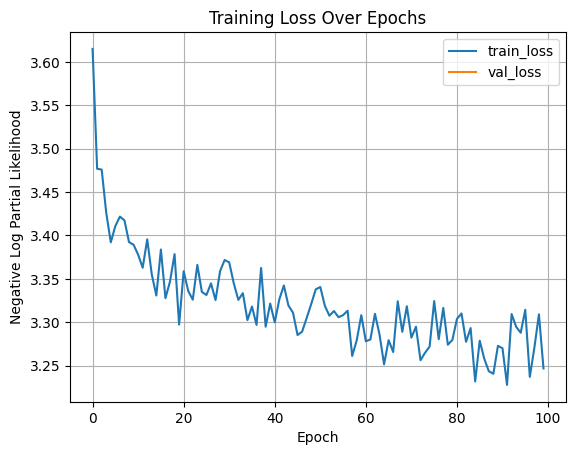

In [9]:
#5

# Make sure no old callbacks interfere
model.callbacks = None

# Train for 100 epochs
log = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=True)

# Plot training loss
log.plot()
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Partial Likelihood")
plt.grid(True)
plt.show()

#Save DeepSurv model using pickle
with open("deepsurv_model.pkl", "wb") as f:
    pickle.dump(model, f)


In [10]:
#6

# Compute baseline hazards
model.compute_baseline_hazards()

# Predict survival curves (test)
surv_test = model.predict_surv_df(X_test)

# C-index (Test)
ev_test = EvalSurv(surv_test, y_test[0], y_test[1], censor_surv='km')
c_index_test = ev_test.concordance_td()
print(f"C-index (Test): {c_index_test:.4f}")

# Median survival time helper
def compute_median_survival_time(surv_df):
    medians = []
    for i in range(surv_df.shape[1]):
        s = surv_df.iloc[:, i]
        below_half = s[s < 0.5]
        if below_half.empty:
            medians.append(np.nan)
        else:
            medians.append(below_half.index[0])
    return np.array(medians)

# RMSE (Test)
pred_median_test = compute_median_survival_time(surv_test)
valid_idx_test = ~np.isnan(pred_median_test)
if valid_idx_test.sum() > 0:
    rmse_test = mean_squared_error(y_test[0][valid_idx_test], pred_median_test[valid_idx_test], squared=False)
    print(f"RMSE (Test): {rmse_test:.4f}")
else:
    print("⚠️ Warning: No valid median predictions (Test)")

# Repeat for training
surv_train = model.predict_surv_df(X_train)
ev_train = EvalSurv(surv_train, y_train[0], y_train[1], censor_surv='km')
c_index_train = ev_train.concordance_td()
print(f"C-index (Train): {c_index_train:.4f}")

pred_median_train = compute_median_survival_time(surv_train)
valid_idx_train = ~np.isnan(pred_median_train)
if valid_idx_train.sum() > 0:
    rmse_train = mean_squared_error(y_train[0][valid_idx_train], pred_median_train[valid_idx_train], squared=False)
    print(f"RMSE (Train): {rmse_train:.4f}")
else:
    print("⚠️ Warning: No valid median predictions (Train)")


C-index (Test): 0.5827
RMSE (Test): 1018.7868
C-index (Train): 0.7457
RMSE (Train): 889.3502


/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


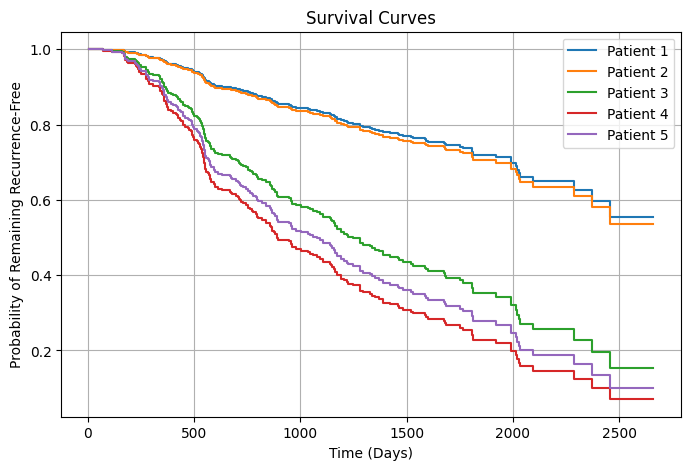

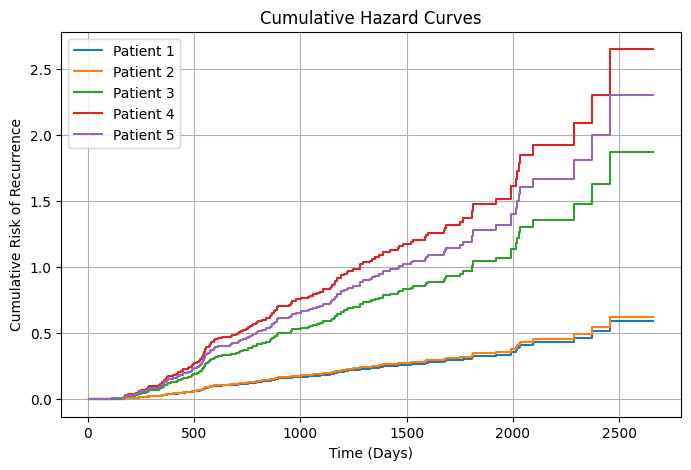

In [7]:
#7



# Select a few patients
X_test_sel = X_test[:5]
surv_sel = model.predict_surv_df(X_test_sel)

# --- A. Survival Curves ---
plt.figure(figsize=(8, 5))
for i, s in enumerate(surv_sel.columns):
    plt.step(surv_sel.index, surv_sel[s], where="post", label=f"Patient {i+1}")
plt.ylabel("Probability of Remaining Recurrence-Free")
plt.xlabel("Time (Days)")
plt.title("Survival Curves")
plt.grid(True)
plt.legend()
plt.show()

# --- B. Cumulative Hazard Curves (from survival) ---
plt.figure(figsize=(8, 5))
for i, s in enumerate(surv_sel.columns):
    cumhaz = -np.log(surv_sel[s].clip(lower=1e-6))  # avoid log(0)
    plt.step(surv_sel.index, cumhaz, where="post", label=f"Patient {i+1}")
plt.ylabel("Cumulative Risk of Recurrence")
plt.xlabel("Time (Days)")
plt.title("Cumulative Hazard Curves")
plt.grid(True)
plt.legend()
plt.show()


In [12]:
# --- Settings ---
# Choose a time point (in days) for which you wish to get the hazard rate.
t_point = 365

# --- Compute or Retrieve Baseline Hazards ---
# Capture the baseline hazards from the model.
# For some versions of pycox, compute_baseline_hazards() returns a pandas Series.
baseline_haz = model.compute_baseline_hazards()

# Check if baseline hazards were successfully computed.
if baseline_haz is None:
    raise ValueError("Baseline hazards were not computed. Please ensure that model.compute_baseline_hazards() "
                     "has been called and is returning the baseline hazards.")

# Interpolate the baseline hazard function at t_point.
baseline_times = baseline_haz.index.values.astype(float)
baseline_values = baseline_haz.values.astype(float)

if t_point > baseline_times.max():
    h0_t = baseline_values[-1]
else:
    h0_t = np.interp(t_point, baseline_times, baseline_values)

# --- Compute Relative Risk and Absolute Hazard ---
# Set the network to evaluation mode.
model.net.eval()
with torch.no_grad():
    # Convert test predictors to a torch tensor.
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    # Compute log-risk scores.
    log_risk = model.net(X_test_tensor).squeeze().numpy()
    # Convert the log-risk to relative risk scores.
    risk_scores = np.exp(log_risk)

# Calculate the absolute hazard rate at t_point:
# h(t|x) = h₀(t) * exp(x·β)
hazard_rates = h0_t * risk_scores

# --- Compute Predicted Median Survival Times ---
# This uses your pre-defined helper to extract the median survival time
predicted_median_times = compute_median_survival_time(surv_test)

# --- Create and Display the Results Table ---
# We use DatTesting.index as the patient identifier.
results_df = pd.DataFrame({
    "Patient_ID": DatTesting.index,
    f"Predicted_Hazard_Rate_at_{t_point}days": hazard_rates,
    "Predicted_Median_Survival_Time": predicted_median_times
})

# Optionally, save the results to a CSV file.
results_df.to_csv("predictions_with_hazard_rate.csv", index=False)

# Display the DataFrame.
display(results_df)

,Patient_ID,Predicted_Hazard_Rate_at_365days,Predicted_Median_Survival_Time
0,435,0.000366,NaN
1,436,0.000387,NaN
2,437,0.001160,1246.0
3,438,0.001642,891.0
4,439,0.001425,1080.0
...,...,...,...
95,679,0.001099,1296.0
96,680,0.000749,1989.0
97,683,0.000761,1918.0
98,684,0.000957,1521.0
